# LSTM Variational autoencoder for time series augmentation

This version uses LSTM-VAE to synthesize aritifical multivariate time series (including response variable y), considering temporal variables "daytime" (minute from midnight) and "dayofweek"(Mon, Tue, ..., Sun). 

"dayofweek" will be used as the label in the visualization of latent representation of original MTS, we can see at the end of this note that the latent variables cluster according to day in a week.

This justifies that, the multivariate time series in energy appliance data has weekly seasonality which has been detected and learnt by the network. Furthermore the effectiveness of the method.

References: 
- [Bowman, Samuel R., et al. "Generating sentences from a continuous space." (2015).](https://arxiv.org/pdf/1511.06349.pdf)
- [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
- [Code examples/ Generative Deep Learning /Variational AutoEncoder](https://keras.io/examples/generative/vae/#train-the-vae)
- [Github repository: keras_lstm_vae](https://github.com/twairball/keras_lstm_vae) 
  NB: In our code, using z_sigma instead of z_log_sigma and correcting the sampling function

In [1]:
# standard modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# ml functions
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression

# lstm_vae class
from tsmall import dl_method

In [2]:
# KNN with GridSearch and cv=3 + applying log transformation to target variable
def run_knn(X_train, Y_train):
    '''run KNN wit CV.

    return: trained model.
    '''
    params_knn = {'n_neighbors':list(np.arange(10, 30, 2))}
    knn = KNeighborsRegressor()
    gs = GridSearchCV(knn, param_grid=params_knn, cv=3, scoring='neg_mean_squared_error')
    tt = TransformedTargetRegressor(regressor=gs, func=np.log1p, inverse_func=np.expm1)
    tt.fit(X_train, Y_train)
    
    return tt

## Data preparation

In [3]:
# load the dataset
energy = pd.read_csv('energy_data.csv', parse_dates=['date'])
energy.set_index('date', inplace=True)

# most important columns, Appliances put in the end
ts_index = ['lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4',
       'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9',
       'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed',
       'Tdewpoint', 'Appliances']

# use the whole energy dataset
data_A = energy[ts_index].copy()    
obs_len = len(data_A)
#data_A['Appliances'] = energy['Appliances'].iloc[:obs_len]

### Temporal variables

Following the most important variable in Fig.11: **the number of seconds from midnight for each day (NSM)**, and variable **day_of_week**, we construct the equivelant two variables: **daytime ($t_d$)**, **dayofweek ($t_w$)**. We treat these two variables as continuous in the following models even though they are quantized.   

In [4]:
# Add temporal variables
data_A['daytime'] = data_A.index.hour + data_A.index.minute/60 #take values of the minutes from the midnight 
data_A['dayofweek'] = data_A.index.dayofweek #take values 0,1,...,6
#data_A['month'] = data_A.index.month

### train-test-split

Unlike the data augmentation methods described in the section XX in the report, since we have LSTM modules in the network, thus **we should not break the temporal structure of data**. Hence, for tran-test-split we simply take the first $75$ percent of data as training set the rest as test set. 

The samll data is constructed by the same spirit, we take the last $10$ percent of data in the training set as the training set of the artificial samll data, while the first $10$ percent of the test set as the samll test set. We train the network later on using the small training set to generate the augmented data for ML model fitting. 

In [5]:
train_size = 0.75
y_A = np.array(data_A.Appliances)
X_A = np.array(data_A.drop(columns='Appliances'))

xtrain_A, xtest_A, ytrain_A, ytest_A = \
        [np.copy(X_A[:int(train_size*obs_len),:]), np.copy(X_A[int(train_size*obs_len):,:]), \
         np.copy(y_A[:int(train_size*obs_len)]), np.copy(y_A[int(train_size*obs_len):])]

# create small data_B
p = 0.1
xtrain_B = xtrain_A[-int(p*train_size*obs_len):,:]
ytrain_B = ytrain_A[-int(p*train_size*obs_len):]

xtest_B = xtest_A[:int(p*(1-train_size)*obs_len),:]
ytest_B = ytest_A[:int(p*(1-train_size)*obs_len)]

# perform data normalization and transformation and input the "standard" data to Network
ss_B_n = StandardScaler()
strain_B = ss_B_n.fit_transform(np.append(xtrain_B, np.log1p(ytrain_B.reshape(-1,1)), axis = 1))
stest_B = ss_B_n.transform(np.append(xtest_B, np.log1p(ytest_B.reshape(-1,1)), axis = 1))
print("The big training set has {} observations".format(xtrain_A.shape[0]))
print("The big test set has {} observations".format(xtest_A.shape[0]))
print("The small training set has {} observations".format(xtrain_B.shape[0]))
print("The small test set has {} observations".format(xtest_B.shape[0]))

The big training set has 14801 observations
The big test set has 4934 observations
The small training set has 1480 observations
The small test set has 493 observations


### Prepare 3D data array for network training 

The training data of network has dimension:(1469, 12, 27)


Text(0.5, 1.0, 'The input for the second feature T1 (after standarization)')

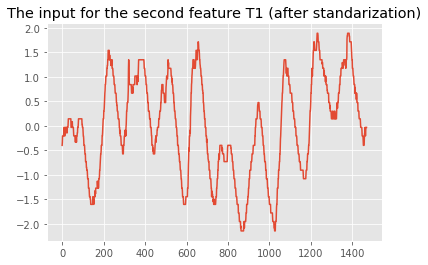

In [6]:
np.random.seed(0)
timesteps = 2*6 #two hours each observation for the network input
x = dl_method.get_data(strain_B, timesteps)
print("The training data of network has dimension:{}".format(x.shape))
plt.plot(x[:,0,1])
plt.title("The input for the second feature T1 (after standarization)")

## Network training
We are in the unsupervised training, so we do not create the validation set here to indicate the *early stopping*, while *epoch* is seen as a hyperparameter too and pre-given by users. 

In [7]:
m = dl_method.lstm_vae(input_dim=27, timesteps=12, batch_size=1, intermediate_dim=500, latent_dim=100, epsilon_std=1)
vae, enc, dec = m.generate_model()
vae.fit(x, x, epochs=200)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
1469/1469 [==============================] - 9s 6ms/step - loss: 1.3904
Epoch 2/200
1469/1469 [==============================] - 8s 5ms/step - loss: 1.0901
Epoch 3/200
1469/1469 [==============================] - 9s 6ms/step - loss: 0.9354
Epoch 4/200
1469/1469 [==============================] - 8s 6ms/step - loss: 0.8174
Epoch 5/200
1469/1469 [==============================] - 8s 5ms/step - loss: 0.7307
Epoch 6/200
1469/1469 [==============================] - 8s 5ms/step - loss: 0.7002
Epoch 7/200
1469/1469 [==============================] - 8s 6ms/step - loss: 0.6565
Epoch 8/200
1469/1469 [==============================] - 8s 5ms/step - loss: 0.5961
Epoch 9/200
1469/1469 [==============================] - 8s 5ms/step - loss: 0.6003
Epoch 10/200
1469/1469 [==============================] - 8s 5ms/step - loss: 0.6244
Epoch 11/200
1469/1469 [===============

1469/1469 [==============================] - 8s 5ms/step - loss: 0.3428
Epoch 186/200
1469/1469 [==============================] - 8s 5ms/step - loss: 0.3126
Epoch 187/200
1469/1469 [==============================] - 8s 5ms/step - loss: 0.3089
Epoch 188/200
1469/1469 [==============================] - 8s 6ms/step - loss: 0.3153
Epoch 189/200
1469/1469 [==============================] - 9s 6ms/step - loss: 0.3205
Epoch 190/200
1469/1469 [==============================] - 9s 6ms/step - loss: 0.3212
Epoch 191/200
1469/1469 [==============================] - 9s 6ms/step - loss: 0.3098
Epoch 192/200
1469/1469 [==============================] - 9s 6ms/step - loss: 0.3115
Epoch 193/200
1469/1469 [==============================] - 9s 6ms/step - loss: 0.3082
Epoch 194/200
1469/1469 [==============================] - 9s 6ms/step - loss: 0.3361
Epoch 195/200
1469/1469 [==============================] - 9s 6ms/step - loss: 0.3114
Epoch 196/200
1469/1469 [==============================] - 8s 6ms/st

## The evaluation of trained network
How much information has been learnt from the input data? Examine from the two aspects
- Input MTS reconstruction 
- Pattern of the latent features of input

### Visualization of the restored MTS
Variational autoencoder learns the posterior distributions of latent variables (**assumed to be Gaussian with diagonal covariance**) instead of a constant feature vector, and it samples a latent feature vector to decode everytime there is an observation being input thus its reconstructions of the same input from two separate runs will be closed but not the same due to the randomness. 

In [8]:
preds = vae.predict(x, batch_size=1)
preds2 = vae.predict(x, batch_size=1)
# Sampling with higher prosibility from the mean 
z_mean, z_sigma, z = enc.predict(x, batch_size=1) # the 
smooth_level = .5
z_ = np.zeros(shape=(len(x), m.latent_dim))
for n in range(len(x)):
    epsilon = np.random.normal(0., scale=smooth_level, size = m.latent_dim)
    z_[n,:] = z_mean[n,:] + z_sigma[n,:] * epsilon
preds3 = dec.predict(z_, batch_size=1)

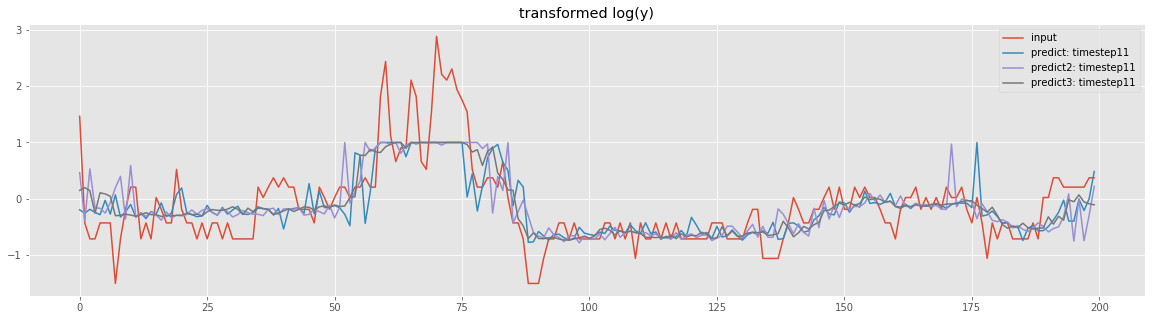

(<matplotlib.legend.Legend at 0x13deb0208>,
 Text(0.5, 1.0, 'transformed log(y)'),
 None)

In [9]:
plt.rcParams['figure.figsize'] = [20, 5]
# visualization of the restored input 
ind = np.arange(0, 200) 
i = 26
plt.figure()
plt.plot(x[ind+11,0,i], label='input'), plt.plot(preds[ind,11,i], label='predict: timestep11')
plt.plot(preds2[ind,11,i], label='predict2: timestep11'), plt.plot(preds3[ind,11,i], label='predict3: timestep11')
plt.legend(), plt.title('transformed log(y)'), plt.show()

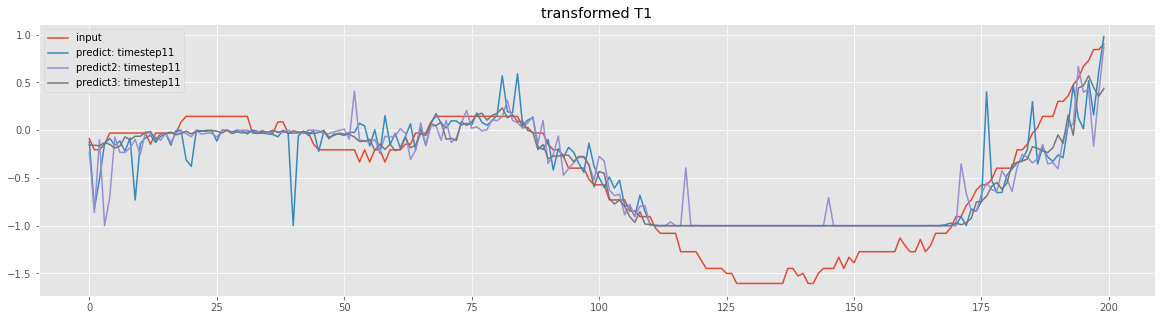

(<matplotlib.legend.Legend at 0x13f6f9898>,
 Text(0.5, 1.0, 'transformed T1'),
 None)

In [10]:
plt.rcParams['figure.figsize'] = [20, 5]
# visualization of the restored input 
ind = np.arange(0, 200)
i = 1
plt.figure()
plt.plot(x[ind+11,0,i], label='input'), plt.plot(preds[ind,11,i], label='predict: timestep11')
plt.plot(preds2[ind,11,i], label='predict2: timestep11'), plt.plot(preds3[ind,11,i], label='predict3: timestep11')
plt.legend(), plt.title('transformed T1'), plt.show()

### Visualization of the means of posterior distributions of input 

No handles with labels found to put in legend.


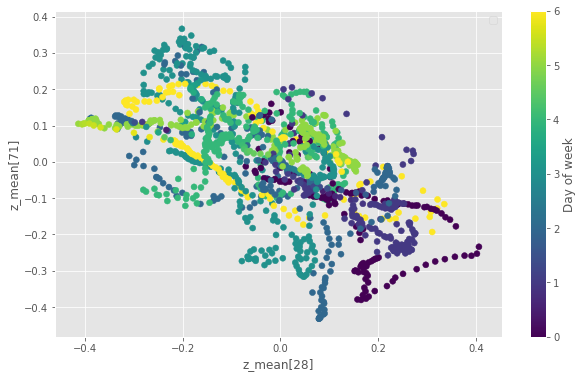

In [15]:
plt.rcParams['figure.figsize'] = [10, 6]
ind = np.arange(0, len(x))
latent_dim = np.argsort(np.mean(z_sigma**2, axis = 0))[-2:]
plt.scatter(z_mean[ind, latent_dim[0]], z_mean[ind, latent_dim[1]], c=np.mean(x[ind, :, 25], axis = 1)*ss_B_n.scale_[25]+ss_B_n.mean_[25])
cbar = plt.colorbar().set_label('Day of week')
plt.xlabel("z_mean[{}]".format(latent_dim[0]))
plt.ylabel("z_mean[{}]".format(latent_dim[1]))
plt.legend()
plt.show()

The figure plots two dimensions of mean latent space and the locations of the corresponding means of input, we can see that the means are significantly different and observations from **the same day of week** tends to have **closer means** while **further means across different day in a week**.

This justifies that the network has learnt meaningful information from the dataset.

## Data augmentation
We use the trained LSTM-VAE to synthesize artificial MTS. Its **direct output** (restored input) can be used as artificial data, furthur more, we can synthesize **smoother/noiser** artificial time series by sampling the latent variables **closer/further** to their means. This feature is tuned through the hyperparameter called **smooth level** in this data augmentation method, which essential corresponds to the scale of standard deviations of latent variables. 

Set it with values in $[0, 0.1)$ to have smoother output, while $>0.1$ to have noiser output.

In [16]:
strain_C = np.concatenate((strain_B, preds3[:,-1,:]), axis = 0)
train_C = ss_B_n.inverse_transform(strain_C)
xtrain_C = train_C[:,:26]
xtrain_C[len(strain_B):,-2:] = xtrain_B[11:,-2:]
ytrain_C = np.expm1(train_C[:,26])

### Add temporal variables of higher orders
As in the previous method this operation is to extract the nolinear trends of MTS. Thus the actual MTS that ML models need to fit is more **homogenous** that is, closer to stationarity assumptions of models. On the other hand, it can increase the **legitimacy** of sampling, that is the sampled datasets (train_A, train_B) are more representive of their own original datasets, so that the data augmentation methods will help to increase the generality of model.

In [17]:
from sklearn.preprocessing import PolynomialFeatures 
poly = PolynomialFeatures(degree = 12) 

ss_A = StandardScaler()
sxtrain_A_t = ss_A.fit_transform(np.append(xtrain_A[:,:24], poly.fit_transform(xtrain_A[:,-2:]), axis = 1))
sxtest_A_t = ss_A.transform(np.append(xtest_A[:,:24], poly.fit_transform(xtest_A[:,-2:]), axis = 1))

ss_B = StandardScaler()
sxtrain_B_t = ss_B.fit_transform(np.append(xtrain_B[:,:24], poly.fit_transform(xtrain_B[:,-2:]), axis = 1))
sxtest_B_t = ss_B.transform(np.append(xtest_B[:,:24], poly.fit_transform(xtest_B[:,-2:]), axis = 1))

ss_C = StandardScaler()
sxtrain_C_t = ss_C.fit_transform(np.append(xtrain_C[:,:24], poly.fit_transform(xtrain_C[:,-2:]), axis = 1))

### Evaluate the DL augmentation method on KNN model

In [19]:
# model fitting
model_A = run_knn(X_train = sxtrain_A_t, Y_train = ytrain_A)
model_B = run_knn(X_train = sxtrain_B_t, Y_train = ytrain_B)
model_C = run_knn(X_train = sxtrain_C_t, Y_train = ytrain_C)

In [20]:
R2_AA = r2_score(ytest_A, model_A.predict(sxtest_A_t))
rmse_AA = mean_squared_error(ytest_A, model_A.predict(sxtest_A_t), squared=False)
display('model_A on test_A:    RMSE {:.2f}    R2 {:.2f}'.format(rmse_AA,R2_AA))

'model_A on test_A:    RMSE 90.23    R2 -0.04'

In [21]:
# initialize list of results
R2_B = np.zeros(2)
R2_C = np.zeros(2)
rmse_B = np.zeros(2)
rmse_C = np.zeros(2)

# save performances    
R2_B[0] = r2_score(ytest_B, model_B.predict(sxtest_B_t))
rmse_B[0] = mean_squared_error(ytest_B, model_B.predict(sxtest_B_t), squared=False)
R2_B[1] = r2_score(ytest_A, model_B.predict(sxtest_A_t))
rmse_B[1] = mean_squared_error(ytest_A, model_B.predict(sxtest_A_t), squared=False)
R2_C[0] = r2_score(ytest_B, model_C.predict(sxtest_B_t))
rmse_C[0] = mean_squared_error(ytest_B, model_C.predict(sxtest_B_t), squared=False)
R2_C[1] = r2_score(ytest_A, model_C.predict(sxtest_A_t))
rmse_C[1] = mean_squared_error(ytest_A, model_C.predict(sxtest_A_t), squared=False)

In [23]:
print('-'*100 + '\n' + 'Results' + '\n' + '-'*100)
display('model_A on test_A:    RMSE {:.2f}    R2 {:.2f}'.format(rmse_AA,R2_AA))
print('-'*100)
display('model_B on test_B:    RMSE {:.2f}    R2 {:.3f} '.format(rmse_B[0], R2_B[0]),\
        'model_B on test_A:    RMSE {:.2f}    R2 {:.3f} '.format(rmse_B[1], R2_B[1]))
print('-'*100)
display('model_C on test_B:    RMSE {:.2f}    R2 {:.3f} '.format(rmse_C[0], R2_C[0]),\
        'model_C on test_A:    RMSE {:.2f}    R2 {:.3f} '.format(rmse_C[1], R2_C[1]))
print('-'*100 + '\n' + 'Size of train_C = {:.0f}'.format(sxtrain_C_t.shape[0])\
              + '\n' + 'Size of train_B = {:.0f}'.format(sxtrain_B_t.shape[0]))

----------------------------------------------------------------------------------------------------
Results
----------------------------------------------------------------------------------------------------


'model_A on test_A:    RMSE 90.23    R2 -0.04'

----------------------------------------------------------------------------------------------------


'model_B on test_B:    RMSE 64.15    R2 -0.050 '

'model_B on test_A:    RMSE 83.49    R2 0.106 '

----------------------------------------------------------------------------------------------------


'model_C on test_B:    RMSE 62.35    R2 0.008 '

'model_C on test_A:    RMSE 82.92    R2 0.118 '

----------------------------------------------------------------------------------------------------
Size of train_C = 2949
Size of train_B = 1480


In [ ]:
plt.rcParams['figure.figsize'] = [20, 5]
plt.plot(ytest_B, label = "true")
plt.plot(model_B.predict(sxtest_B_t), label = "pred_B")
plt.plot(model_C.predict(sxtest_B_t), label = "pred_C")
plt.legend()